In [1]:
import numpy as np
import pandas as pd
import wrds
import datetime as dt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("/Users/dhruvishah/Desktop/Quant_Fin/SEM 2/Dissertation/final_data/outsamp_finbert_out_headlines.csv")
df.returns = df.returns/3

In [3]:
# changes = pd.read_csv('change_returns.csv')
# for i in df.compname.unique().tolist():
#     df.loc[df.compname==i, 'returns'] = changes[i]
# df

In [4]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,week,FROM,TO,headline,clean_headline,returns,tf-idf,sentiment,sent_score,compname,label,score
0,1,04/01/16,22/01/16,kinem enter strateg proteom biomark discoveri ...,kinem enter strateg proteom biomark discoveri ...,-1.621247,3.253156,positive,1,PFE,neutral,0.921869
1,1,04/01/16,22/01/16,corpor present jpmorgan annual healthcar confe...,corpor present jpmorgan annual healthcar confe...,0.347941,0.000000,neutral,0,SYK,neutral,0.925315
2,1,04/01/16,22/01/16,eli lilli compani present jpmorgan annual heal...,eli lilli compani present jpmorgan annual heal...,-0.704184,0.000000,neutral,0,LLY,neutral,0.907381
3,1,04/01/16,22/01/16,sach associ ltd annual cancer biopartn invest ...,sach associ ltd annual cancer biopartn invest ...,-2.127243,-0.742992,negative,2,BMY,neutral,0.935652
4,1,04/01/16,22/01/16,sach associ ltd annual european life scienc ce...,sach associ ltd annual european life scienc ce...,-0.264329,0.372423,positive,1,GSK,neutral,0.916434
...,...,...,...,...,...,...,...,...,...,...,...,...
6981,363,12/12/22,30/12/22,cv corpor earn call feb.hmg strategi llc centr...,cv corpor earn call feb hmg strategi llc centr...,-2.774265,3.403083,positive,1,CVS,neutral,0.931996
6982,363,12/12/22,30/12/22,berkeley light nasdaqgsbl announc definit agre...,berkeley light nasdaqgsbl announc definit agre...,-0.454343,0.000000,neutral,0,DHR,neutral,0.918330
6983,363,12/12/22,30/12/22,gsk plc announc new global headquart central l...,gsk plc announc new global headquart central l...,-0.769113,2.055391,positive,1,GSK,neutral,0.927624
6984,363,12/12/22,30/12/22,bristol myer squibb announc first disclosur ne...,bristol myer squibb announc first disclosur ne...,-2.909204,1.042762,positive,1,BMY,neutral,0.946162


In [5]:
ticks = df.compname.unique().tolist()
weeks = df.week.unique().tolist()

In [6]:
mktcap = pd.read_csv("/Users/dhruvishah/Desktop/Quant_Fin/SEM 2/Dissertation/mktcap2016.csv")
mktcap.sort_values(by="Market Capitalization", inplace=True, ascending=False)
mktcap = mktcap.loc[mktcap['Ticker Name'].isin(ticks)]
mktcap.reset_index(drop=True, inplace=True)

In [7]:
cap = mktcap['Market Capitalization'].sum()
for i in range(len(mktcap["Ticker Name"])):
#     temp = df[df.compname==i]
#     temp.loc['']
#     df.loc[df.compname==mktcap["Ticker Name"][i], 'vw'] = mktcap['Market Capitalisation'][i]/cap
    df.loc[df.compname==mktcap["Ticker Name"][i], 'mkt_cap'] = mktcap['Market Capitalization'][i]

In [8]:
df_pos = df[df.label!="negative"]
df_neg = df[df.label!="positive"]
df_pos['Rank'] = df_pos.groupby(['week', 'label'])['score'].rank(method='first', ascending=False)
df_neg['Rank'] = df_neg.groupby(['week', 'label'])['score'].rank(method='first', ascending=False)
# df_pos['Rank_lm'] = df_pos.groupby(['week', 'sentiment'])['tf-idf'].rank(method='first', ascending=False)
# df_neg['Rank_lm'] = df_neg.groupby(['week', 'sentiment'])['tf-idf'].rank(method='first', ascending=False)

/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/3480695599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['Rank'] = df_pos.groupby(['week', 'label'])['score'].rank(method='first', ascending=False)
/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/3480695599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['Rank'] = df_neg.groupby(['week', 'label'])['score'].rank(method='first', ascending=False)


In [9]:
mktcap['Market Capitalization'].sum()

1786551310.65

In [10]:
def get_portfolio_long_ew(frame):
    ret = [0]
    cum_ret = 0
    for i in weeks[1:]:
        temp = frame[frame.week == i]
        stock = max(temp.Rank) - 4
        mid_df = temp[temp.Rank >= stock]
        if len(mid_df) > 5:
            idx = 5-len(mid_df)
            mid_df = mid_df[:idx]
        weights = 1/len(mid_df)
        returns = sum(mid_df.returns*weights)
        cum_ret = returns
        ret.append(cum_ret) 
    return ret 

# fig = plt.figure()
# ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
# ax1.plot(get_portfolio_long_ew(df_pos))
# ax1.set_xlabel('Date')
# ax1.set_ylabel("Cumulative Returns")
# ax1.set_title("Long Portfolio Cumulative Returns")
# plt.show()

In [11]:
def get_portfolio_short_ew(frame):
    ret = [0]
    cum_ret = 0
    for i in weeks[1:]:
        temp = frame[frame.week == i]
#         stock = min(temp.Rank) - 4
        mid_df = temp[temp.Rank <= 5]
        if len(mid_df) > 5:
            idx = 5-len(mid_df)
            mid_df = mid_df[:idx]
        weights = 1/len(mid_df)
        returns = sum(mid_df.returns*weights)
        cum_ret = returns
        ret.append(cum_ret) 
    return ret 

In [12]:
def get_portfolio_long_vw(frame):
    ret = [0]
    cum_ret = 0
    for i in weeks[1:]:
        temp = frame[frame.week == i]
        stock = max(temp.Rank) - 4
        mid_df = temp[temp.Rank >= stock]
        if len(mid_df) > 5:
            idx = 5-len(mid_df)
            mid_df = mid_df[:idx]
        cap_sum = sum(mid_df.mkt_cap)
        weights = mid_df.mkt_cap/cap_sum
        returns = sum(mid_df.returns*weights)
#         returns = sum(mid_df.returns*mid_df.vw)
        cum_ret = returns
        ret.append(cum_ret) 
    return ret 
# get_portfolio_long_vw(df_pos)

In [13]:
def get_portfolio_short_vw(frame):
    ret = [0]
    cum_ret = 0
    for i in weeks[1:]:
        temp = frame[frame.week == i]
#         stock = min(temp.Rank) - 4
        mid_df = temp[temp.Rank <= 5]
        if len(mid_df) > 5:
            idx = 5-len(mid_df)
            mid_df = mid_df[:idx]
        cap_sum = sum(mid_df.mkt_cap)
        weights = mid_df.mkt_cap/cap_sum
        returns = sum(mid_df.returns*weights)
#         returns = sum(mid_df.returns*mid_df.vw)
        cum_ret = returns
        ret.append(cum_ret)
    return ret
# get_portfolio_short_vw(df_neg)

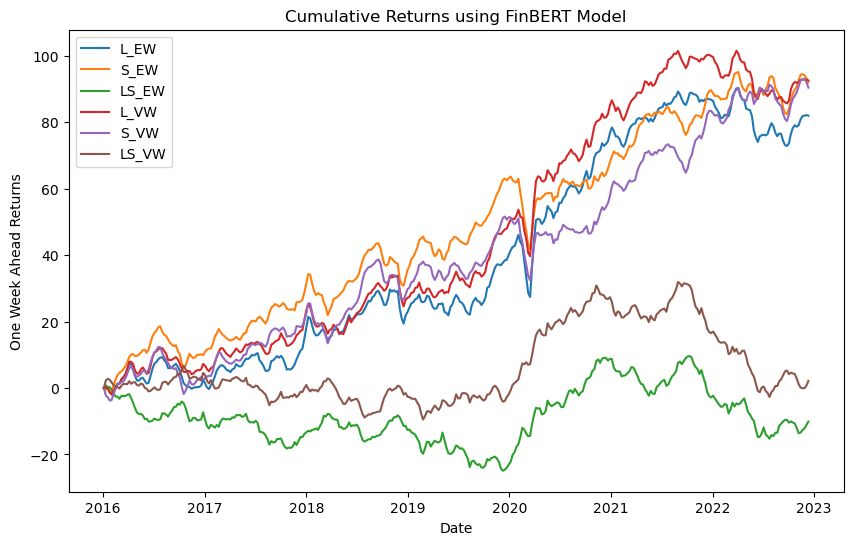

In [54]:
df['FROM'] = pd.to_datetime(df['FROM'], format='%d/%m/%y')
l_ew = pd.Series(get_portfolio_long_ew(df_pos))
s_ew = pd.Series(get_portfolio_short_ew(df_neg))
ls_ew = l_ew+(-1*s_ew)
l_vw = pd.Series(get_portfolio_long_vw(df_pos))
s_vw = pd.Series(get_portfolio_short_vw(df_neg))
ls_vw = l_vw+(-1*s_vw)
yrs = pd.DatetimeIndex(df['FROM']).unique().tolist()
plt.figure(figsize=(10, 6))  # Set the figure size

# # Plot the lines
# plt.plot(yrs, (1+l_ew).cumprod(), label='L_EW')
# plt.plot(yrs, (1+s_ew).cumprod(), label='S_EW')
# plt.plot(yrs, (1+ls_ew).cumprod(), label='LS_EW')
# plt.plot(yrs, (1+l_vw).cumprod(), label='L_VW')
# plt.plot(yrs, (1+s_vw).cumprod(), label='S_VW')
# plt.plot(yrs, (1+ls_vw).cumprod(), label='LS_VW')

plt.plot(yrs, np.cumsum(l_ew), label='L_EW')
plt.plot(yrs, np.cumsum(s_ew), label='S_EW')
plt.plot(yrs, np.cumsum(ls_ew), label='LS_EW')
plt.plot(yrs, np.cumsum(l_vw), label='L_VW')
plt.plot(yrs, np.cumsum(s_vw), label='S_VW')
plt.plot(yrs, np.cumsum(ls_vw), label='LS_VW')
plt.xlabel('Date')  # Replace with your actual x-axis label
plt.ylabel('One Week Ahead Returns')
plt.title('Cumulative Returns using FinBERT Model')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [15]:
(1 + l_ew).cumprod()

0      1.000000e+00
1      1.253552e+00
2      1.063942e+00
3     -2.270026e-01
4     -6.060309e-02
           ...     
358   -6.514255e+09
359   -1.256651e+10
360   -1.394064e+10
361   -1.700177e+10
362   -1.341527e+10
Length: 363, dtype: float64

In [16]:
df.label.fillna('')
print("Accuracy score for outsample data finbert model = ", accuracy_score(df.sentiment,df.label.fillna('')))

Accuracy score for outsample data finbert model =  0.33610077297452046


In [17]:
port_vals = pd.DataFrame(columns=['avg', 'stdev', 'std_downside', 'sharpe_ratio', 'sortino_ratio','ff3_alpha', 'ff3_r2', 'ff5_alpha', 'ff5_r2'])

In [18]:
avg = [np.mean(l_ew)] + [np.mean(s_ew)] + [np.mean(ls_ew)] + [np.mean(l_vw)] + [np.mean(s_vw)] + [np.mean(ls_vw)] 
stdev = [np.std(l_ew)] + [np.std(s_ew)] + [np.std(ls_ew)] + [np.std(l_vw)] + [np.std(s_vw)] + [np.std(ls_vw)]

In [19]:
downside = [np.std(l_ew[l_ew < 0]), np.std(s_ew[s_ew < 0]), np.std(ls_ew[ls_ew < 0]),np.std(l_vw[l_vw < 0]),
            np.std(s_vw[s_vw < 0]), np.std(ls_vw[ls_vw < 0])]
# np.std(l_ew[l_ew < 0])
# down_s_ew = np.std(s_ew[s_ew < 0])
# down_ls_ew = np.std(ls_ew[ls_ew < 0])

In [20]:
port_vals['avg'] = avg
port_vals['stdev'] = stdev
port_vals['std_downside'] = downside

In [21]:
new_index = ['l_ew', 's_ew', 'ls_ew', 'l_vw', 's_vw', 'ls_vw']
port_vals = port_vals.set_index(pd.Index(new_index))

In [22]:
port_vals

,avg,stdev,std_downside,sharpe_ratio,sortino_ratio,ff3_alpha,ff3_r2,ff5_alpha,ff5_r2
l_ew,0.225800,1.514119,0.964212,NaN,NaN,NaN,NaN,NaN,NaN
s_ew,0.253670,1.370762,0.974344,NaN,NaN,NaN,NaN,NaN,NaN
ls_ew,-0.027870,1.093567,0.693212,NaN,NaN,NaN,NaN,NaN,NaN
l_vw,0.255008,1.420037,0.820799,NaN,NaN,NaN,NaN,NaN,NaN
s_vw,0.249090,1.366329,0.910604,NaN,NaN,NaN,NaN,NaN,NaN
ls_vw,0.005918,1.088526,0.647464,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
for i in range(len(port_vals)):
    port_vals.sharpe_ratio[i]=(port_vals.avg[i]-0.008)/port_vals.stdev[i]
    port_vals.sortino_ratio[i]=(port_vals.avg[i]-0.008)/port_vals.std_downside[i]
port_vals

/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/2852972423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port_vals.sharpe_ratio[i]=(port_vals.avg[i]-0.008)/port_vals.stdev[i]
/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/2852972423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port_vals.sortino_ratio[i]=(port_vals.avg[i]-0.008)/port_vals.std_downside[i]


,avg,stdev,std_downside,sharpe_ratio,sortino_ratio,ff3_alpha,ff3_r2,ff5_alpha,ff5_r2
l_ew,0.225800,1.514119,0.964212,0.143846,0.225884,NaN,NaN,NaN,NaN
s_ew,0.253670,1.370762,0.974344,0.179222,0.252139,NaN,NaN,NaN,NaN
ls_ew,-0.027870,1.093567,0.693212,-0.032801,-0.051745,NaN,NaN,NaN,NaN
l_vw,0.255008,1.420037,0.820799,0.173945,0.300937,NaN,NaN,NaN,NaN
s_vw,0.249090,1.366329,0.910604,0.176451,0.264758,NaN,NaN,NaN,NaN
ls_vw,0.005918,1.088526,0.647464,-0.001912,-0.003215,NaN,NaN,NaN,NaN


In [24]:
ff3 = pd.read_csv("ff3.csv")
ff3.date = pd.to_datetime(ff3['date'], format='%d/%m/%y')
ff3.set_index('date', inplace=True)

weekly_first_days = ff3.resample('W-MON').first()

weekly_first_days = weekly_first_days.dropna()

start = weekly_first_days.index.strftime('%d/%m/%y').tolist()
start_list = start[:-3]

weekly_last_days = ff3.resample('W-FRI').last()

weekly_last_days = weekly_last_days.dropna()

end = weekly_last_days.index.strftime('%d/%m/%y').tolist()
end_list = end[2:]

weekly_df = pd.DataFrame(columns=[['FROM'] +['TO']])
start_list = pd.to_datetime(start_list, format='%d/%m/%y')
end_list = pd.to_datetime(end_list, format='%d/%m/%y')
start_list = start_list.sort_values()
end_list = end_list.sort_values()

In [25]:
cols = ff3.columns.tolist()
weekly_df = pd.DataFrame(columns= cols)
for i in range(len(start_list)):
    start_date = start_list[i]
    end_date = end_list[i]
    selected_data = ff3[(ff3.index >= start_date) & (ff3.index <= end_date)]
    data = selected_data.sum()
    data = pd.DataFrame(data).T
    weekly_df = pd.concat([weekly_df, data])

In [26]:
weekly_df['date'] = start_list
weekly = weekly_df.loc[weekly_df['date'].isin(df.FROM.unique())]
weekly.reset_index(drop=True, inplace=True)
weekly_df

,mktrf,smb,hml,rf,umd,date
0,-0.0747,-0.0312,-0.0117,0.00000,0.0268,2016-01-04
0,0.0066,-0.0166,0.0184,0.00000,-0.0033,2016-01-11
0,-0.0021,-0.0179,0.0313,0.00005,-0.0643,2016-01-18
0,-0.0238,-0.0258,0.0430,0.00010,-0.0246,2016-01-25
0,-0.0106,-0.0120,-0.0083,0.00014,-0.0300,2016-02-01
...,...,...,...,...,...,...
0,0.0175,-0.0096,-0.0079,0.00200,0.0408,2022-11-14
0,-0.0108,-0.0070,-0.0212,0.00210,-0.0079,2022-11-21
0,-0.0459,-0.0003,-0.0284,0.00234,-0.0015,2022-11-28
0,-0.0625,-0.0220,0.0252,0.00240,0.0652,2022-12-05


In [27]:
weekly['l_ew'] = l_ew
weekly['s_ew'] = s_ew
weekly['ls_ew'] = ls_ew
weekly['l_vw'] = l_vw
weekly['s_vw'] = s_vw
weekly['ls_vw'] = ls_vw

In [28]:
weekly

,mktrf,smb,hml,rf,umd,date,l_ew,s_ew,ls_ew,l_vw,s_vw,ls_vw
0,-0.0747,-0.0312,-0.0117,0.00000,0.0268,2016-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0066,-0.0166,0.0184,0.00000,-0.0033,2016-01-11,0.253552,-0.575198,0.828750,0.029254,-2.254401,2.283655
2,-0.0021,-0.0179,0.0313,0.00005,-0.0643,2016-01-18,-0.151258,0.413729,-0.564988,-0.020812,-0.514593,0.493781
3,-0.0238,-0.0258,0.0430,0.00010,-0.0246,2016-01-25,-1.213360,-1.221032,0.007672,-1.318192,-0.995091,-0.323101
4,-0.0106,-0.0120,-0.0083,0.00014,-0.0300,2016-02-01,-0.733029,0.002419,-0.735448,-0.636811,0.138329,-0.775140
...,...,...,...,...,...,...,...,...,...,...,...,...
358,0.0175,-0.0096,-0.0079,0.00200,0.0408,2022-11-14,1.794514,1.587818,0.206696,0.772934,1.751819,-0.978885
359,-0.0108,-0.0070,-0.0212,0.00210,-0.0079,2022-11-21,0.929078,0.172136,0.756943,0.050384,0.251628,-0.201244
360,-0.0459,-0.0003,-0.0284,0.00234,-0.0015,2022-11-28,0.109349,-0.372933,0.482282,0.050058,0.041763,0.008295
361,-0.0625,-0.0220,0.0252,0.00240,0.0652,2022-12-05,0.219583,-0.866881,1.086464,-0.088808,-0.857317,0.768508


In [29]:
import statsmodels.api as sm

ports = ['l_ew', 's_ew', 'ls_ew', 'l_vw', 's_vw', 'ls_vw']

for i in range(len(ports)):
    X = weekly[['mktrf', 'smb', 'hml','umd']]  # Independent variables
    X = sm.add_constant(X)  # Add a constant term
    y = weekly[ports[i]]  # Dependent variable
    model = sm.OLS(y, X).fit()
    port_vals.ff3_alpha[i] = model.params['const']
    port_vals.ff3_r2[i] = model.rsquared*100
port_vals

/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/3896336128.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port_vals.ff3_alpha[i] = model.params['const']
/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/3896336128.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port_vals.ff3_r2[i] = model.rsquared*100
/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/3896336128.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,avg,stdev,std_downside,sharpe_ratio,sortino_ratio,ff3_alpha,ff3_r2,ff5_alpha,ff5_r2
l_ew,0.225800,1.514119,0.964212,0.143846,0.225884,0.025812,56.52707,NaN,NaN
s_ew,0.253670,1.370762,0.974344,0.179222,0.252139,0.070193,56.136019,NaN,NaN
ls_ew,-0.027870,1.093567,0.693212,-0.032801,-0.051745,-0.044382,1.336938,NaN,NaN
l_vw,0.255008,1.420037,0.820799,0.173945,0.300937,0.080245,48.019295,NaN,NaN
s_vw,0.249090,1.366329,0.910604,0.176451,0.264758,0.082776,46.803286,NaN,NaN
ls_vw,0.005918,1.088526,0.647464,-0.001912,-0.003215,-0.00253,0.996196,NaN,NaN


In [30]:
port_vals

,avg,stdev,std_downside,sharpe_ratio,sortino_ratio,ff3_alpha,ff3_r2,ff5_alpha,ff5_r2
l_ew,0.225800,1.514119,0.964212,0.143846,0.225884,0.025812,56.52707,NaN,NaN
s_ew,0.253670,1.370762,0.974344,0.179222,0.252139,0.070193,56.136019,NaN,NaN
ls_ew,-0.027870,1.093567,0.693212,-0.032801,-0.051745,-0.044382,1.336938,NaN,NaN
l_vw,0.255008,1.420037,0.820799,0.173945,0.300937,0.080245,48.019295,NaN,NaN
s_vw,0.249090,1.366329,0.910604,0.176451,0.264758,0.082776,46.803286,NaN,NaN
ls_vw,0.005918,1.088526,0.647464,-0.001912,-0.003215,-0.00253,0.996196,NaN,NaN


# Ratios - 
avg return, std, sharpe ratio, sortino 

In [31]:
ff5 = pd.read_csv("ff5.csv")
ff5.date = pd.to_datetime(ff5['date'], format='%d/%m/%y')
ff5.set_index('date', inplace=True)
# cols = ff3.columns.tolist()
weekly_df_ff5 = pd.DataFrame(columns= cols)
for i in range(len(start_list)):
    start_date = start_list[i]
    end_date = end_list[i]
    selected_data = ff5[(ff5.index >= start_date) & (ff5.index <= end_date)]
    data = selected_data.sum()
    data = pd.DataFrame(data).T
    weekly_df_ff5 = pd.concat([weekly_df_ff5, data])
weekly_df_ff5['date'] = start_list
weekly_ff5 = weekly_df_ff5.loc[weekly_df_ff5['date'].isin(df.FROM.unique())]
weekly_ff5.reset_index(drop=True, inplace=True)

weekly_ff5['l_ew'] = l_ew
weekly_ff5['s_ew'] = s_ew
weekly_ff5['ls_ew'] = ls_ew
weekly_ff5['l_vw'] = l_vw
weekly_ff5['s_vw'] = s_vw
weekly_ff5['ls_vw'] = ls_vw
weekly_ff5

,mktrf,smb,hml,rf,umd,rmw,cma,date,l_ew,s_ew,ls_ew,l_vw,s_vw,ls_vw
0,-0.0747,-0.0341,-0.0117,0.00000,0.0268,0.0244,0.0151,2016-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0066,-0.0166,0.0184,0.00000,-0.0033,0.0170,0.0183,2016-01-11,0.253552,-0.575198,0.828750,0.029254,-2.254401,2.283655
2,-0.0021,-0.0145,0.0313,0.00005,-0.0643,0.0301,0.0273,2016-01-18,-0.151258,0.413729,-0.564988,-0.020812,-0.514593,0.493781
3,-0.0238,-0.0203,0.0430,0.00010,-0.0246,0.0396,0.0318,2016-01-25,-1.213360,-1.221032,0.007672,-1.318192,-0.995091,-0.323101
4,-0.0106,-0.0111,-0.0083,0.00014,-0.0300,0.0273,0.0117,2016-02-01,-0.733029,0.002419,-0.735448,-0.636811,0.138329,-0.775140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,0.0175,-0.0119,-0.0079,0.00200,0.0408,0.0222,0.0200,2022-11-14,1.794514,1.587818,0.206696,0.772934,1.751819,-0.978885
359,-0.0108,-0.0131,-0.0212,0.00210,-0.0079,0.0070,0.0078,2022-11-21,0.929078,0.172136,0.756943,0.050384,0.251628,-0.201244
360,-0.0459,-0.0050,-0.0284,0.00234,-0.0015,-0.0007,0.0034,2022-11-28,0.109349,-0.372933,0.482282,0.050058,0.041763,0.008295
361,-0.0625,-0.0143,0.0252,0.00240,0.0652,0.0218,0.0361,2022-12-05,0.219583,-0.866881,1.086464,-0.088808,-0.857317,0.768508


In [32]:
import statsmodels.api as sm

ports = ['l_ew', 's_ew', 'ls_ew', 'l_vw', 's_vw', 'ls_vw']

for i in range(len(ports)):
    X = weekly_ff5[['mktrf', 'smb', 'hml','umd']]  # Independent variables
    X = sm.add_constant(X)  # Add a constant term
    y = weekly_ff5[ports[i]]  # Dependent variable
    model = sm.OLS(y, X).fit()
    port_vals.ff5_alpha[i] = model.params['const']
    port_vals.ff5_r2[i] = model.rsquared*100
port_vals

/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/149249534.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port_vals.ff5_alpha[i] = model.params['const']
/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/149249534.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port_vals.ff5_r2[i] = model.rsquared*100
/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/149249534.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

,avg,stdev,std_downside,sharpe_ratio,sortino_ratio,ff3_alpha,ff3_r2,ff5_alpha,ff5_r2
l_ew,0.225800,1.514119,0.964212,0.143846,0.225884,0.025812,56.52707,0.026036,56.374181
s_ew,0.253670,1.370762,0.974344,0.179222,0.252139,0.070193,56.136019,0.070542,55.989477
ls_ew,-0.027870,1.093567,0.693212,-0.032801,-0.051745,-0.044382,1.336938,-0.044506,1.335677
l_vw,0.255008,1.420037,0.820799,0.173945,0.300937,0.080245,48.019295,0.080077,47.845238
s_vw,0.249090,1.366329,0.910604,0.176451,0.264758,0.082776,46.803286,0.083437,46.67824
ls_vw,0.005918,1.088526,0.647464,-0.001912,-0.003215,-0.00253,0.996196,-0.00336,1.065201


In [33]:
ff3_mom_r2 = []
ff3_mom_alpha = []
for i in range(len(ports)):
    X = weekly[['mktrf', 'smb', 'hml','umd']]  # Independent variables
    X = sm.add_constant(X)  # Add a constant term
    y = weekly[ports[i]]  # Dependent variable
    model = sm.OLS(y, X).fit()
    ff3_mom_alpha.append(model.params['const'])
    ff3_mom_r2.append(model.rsquared*100)
port_vals.ff3_mom_alpha = ff3_mom_alpha
port_vals.ff3_mom_r2 = ff3_mom_r2

ff5_mom_r2 = []
ff5_mom_alpha = []
for i in range(len(ports)):
    X = weekly_ff5[['mktrf', 'smb', 'hml','umd']]  # Independent variables
    X = sm.add_constant(X)  # Add a constant term
    y = weekly[ports[i]]  # Dependent variable
    model = sm.OLS(y, X).fit()
    ff5_mom_alpha.append(model.params['const'])
    ff5_mom_r2.append(model.rsquared*100)
port_vals['ff5_mom_alpha'] = ff5_mom_alpha
port_vals['ff5_mom_r2'] = ff5_mom_r2

/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/1293942564.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  port_vals.ff3_mom_alpha = ff3_mom_alpha
/var/folders/jq/fqfft7b52px1bqqsk7z53vnc0000gn/T/ipykernel_39240/1293942564.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  port_vals.ff3_mom_r2 = ff3_mom_r2


In [34]:
port_vals

,avg,stdev,std_downside,sharpe_ratio,sortino_ratio,ff3_alpha,ff3_r2,ff5_alpha,ff5_r2,ff5_mom_alpha,ff5_mom_r2
l_ew,0.225800,1.514119,0.964212,0.143846,0.225884,0.025812,56.52707,0.026036,56.374181,0.026036,56.374181
s_ew,0.253670,1.370762,0.974344,0.179222,0.252139,0.070193,56.136019,0.070542,55.989477,0.070542,55.989477
ls_ew,-0.027870,1.093567,0.693212,-0.032801,-0.051745,-0.044382,1.336938,-0.044506,1.335677,-0.044506,1.335677
l_vw,0.255008,1.420037,0.820799,0.173945,0.300937,0.080245,48.019295,0.080077,47.845238,0.080077,47.845238
s_vw,0.249090,1.366329,0.910604,0.176451,0.264758,0.082776,46.803286,0.083437,46.67824,0.083437,46.678240
ls_vw,0.005918,1.088526,0.647464,-0.001912,-0.003215,-0.00253,0.996196,-0.00336,1.065201,-0.003360,1.065201


In [35]:
port_final = port_vals.copy()
port_final.sharpe_ratio = port_final.sharpe_ratio*np.sqrt(52)
port_final.stdev = port_final.stdev*np.sqrt(52)
port_final.avg = (((1+port_final.avg)**(1/52))-1)*52*100
port_final.sortino_ratio = port_final.sortino_ratio*np.sqrt(52)
port_final

,avg,stdev,std_downside,sharpe_ratio,sortino_ratio,ff3_alpha,ff3_r2,ff5_alpha,ff5_r2,ff5_mom_alpha,ff5_mom_r2
l_ew,20.399288,10.918467,0.964212,1.037289,1.628872,0.025812,56.52707,0.026036,56.374181,0.026036,56.374181
s_ew,22.656771,9.884709,0.974344,1.292386,1.818202,0.070193,56.136019,0.070542,55.989477,0.070542,55.989477
ls_ew,-2.825832,7.885824,0.693212,-0.236532,-0.373139,-0.044382,1.336938,-0.044506,1.335677,-0.044506,1.335677
l_vw,22.763907,10.240032,0.820799,1.254335,2.170085,0.080245,48.019295,0.080077,47.845238,0.080077,47.845238
s_vw,22.289168,9.852741,0.910604,1.272406,1.909199,0.082776,46.803286,0.083437,46.67824,0.083437,46.678240
ls_vw,0.590121,7.849474,0.647464,-0.01379,-0.023185,-0.00253,0.996196,-0.00336,1.065201,-0.003360,1.065201


In [36]:
port_final

,avg,stdev,std_downside,sharpe_ratio,sortino_ratio,ff3_alpha,ff3_r2,ff5_alpha,ff5_r2,ff5_mom_alpha,ff5_mom_r2
l_ew,20.399288,10.918467,0.964212,1.037289,1.628872,0.025812,56.52707,0.026036,56.374181,0.026036,56.374181
s_ew,22.656771,9.884709,0.974344,1.292386,1.818202,0.070193,56.136019,0.070542,55.989477,0.070542,55.989477
ls_ew,-2.825832,7.885824,0.693212,-0.236532,-0.373139,-0.044382,1.336938,-0.044506,1.335677,-0.044506,1.335677
l_vw,22.763907,10.240032,0.820799,1.254335,2.170085,0.080245,48.019295,0.080077,47.845238,0.080077,47.845238
s_vw,22.289168,9.852741,0.910604,1.272406,1.909199,0.082776,46.803286,0.083437,46.67824,0.083437,46.678240
ls_vw,0.590121,7.849474,0.647464,-0.01379,-0.023185,-0.00253,0.996196,-0.00336,1.065201,-0.003360,1.065201


In [37]:
port_final.to_csv('fin_port_vals.csv')

In [38]:
2470/7260

0.3402203856749311

In [39]:
from sklearn.metrics import precision_score

In [40]:
print("Precision score for outsample data finbert model = ", precision_score(df.sentiment,df.label, average='weighted'))

Precision score for outsample data finbert model =  0.5632816299712081


In [41]:
y_true = [[1, 1, 0], [0, 0, 0], [0, 1, 1]]
y_pred = [[0, 0, 0], [1, 1, 1], [1, 1, 0]]
precision_score(y_true, y_pred, average='micro')

0.2

In [42]:
from sklearn.metrics import recall_score

print("Precision score for outsample data finbert model = ", recall_score(df.sentiment,df.label, average='weighted'))

Precision score for outsample data finbert model =  0.33610077297452046


In [43]:
from sklearn.metrics import f1_score

print("Precision score for outsample data finbert model = ", f1_score(df.sentiment,df.label, average='weighted'))

Precision score for outsample data finbert model =  0.17291530690854845


In [44]:
print('l',np.cumsum(l_ew)[-1:],'\n')
print('s',np.cumsum(s_ew)[-1:],'\n')
print('ls',np.cumsum(ls_ew)[-1:],'\n')
print('l vw',np.cumsum(l_vw)[-1:],'\n')
print('s vw',np.cumsum(s_vw)[-1:],'\n')
print('ls vw',np.cumsum(ls_vw)[-1:],'\n')

l 362    81.965447
dtype: float64 

s 362    92.08235
dtype: float64 

ls 362   -10.116902
dtype: float64 

l vw 362    92.568044
dtype: float64 

s vw 362    90.419695
dtype: float64 

ls vw 362    2.148349
dtype: float64 



In [45]:
l_vw = pd.DataFrame(np.cumsum(l_vw))
l_vw.to_csv('fin_lv.csv')

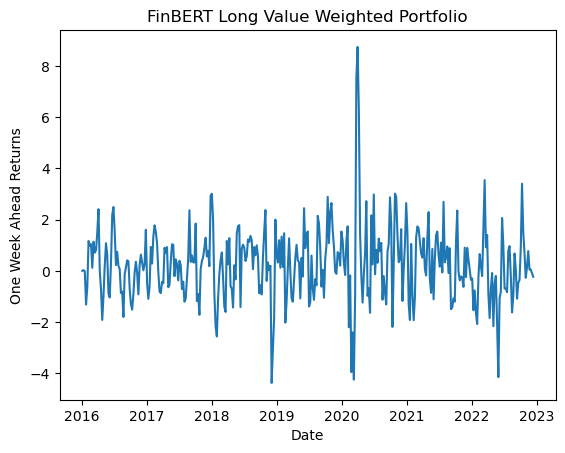

In [60]:
plt.plot(yrs, l_vw, label='FinBERT LVW')
plt.xlabel('Date')  # Replace with your actual x-axis label
plt.ylabel('One Week Ahead Returns')
plt.title('FinBERT Long Value Weighted Portfolio')
# plt.legend()

# Show the plot
plt.show()